# Cifar-10

In [1]:
# Loading Libraries
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# CIFAR dataset
train_dataset = torchvision.datasets.CIFAR10(root='/data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='/data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)


Files already downloaded and verified


In [4]:
num_epochs = 5
num_classes = 10
learning_rate = 0.001

In [5]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(8*8*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


In [6]:
model = ConvNet(num_classes).to(device)

In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
total_step = len(train_loader)
Loss=[]
for epoch in range(num_epochs):
    l=[]
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l.append(loss.item())
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    Loss.append(sum(l)/len(l))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/5], Step [100/500], Loss: 1.5747
Epoch [1/5], Step [200/500], Loss: 1.3245
Epoch [1/5], Step [300/500], Loss: 1.2101
Epoch [1/5], Step [400/500], Loss: 1.2712
Epoch [1/5], Step [500/500], Loss: 1.1287
Epoch [2/5], Step [100/500], Loss: 0.9771
Epoch [2/5], Step [200/500], Loss: 1.2176
Epoch [2/5], Step [300/500], Loss: 1.0089
Epoch [2/5], Step [400/500], Loss: 0.9954
Epoch [2/5], Step [500/500], Loss: 0.9614
Epoch [3/5], Step [100/500], Loss: 0.9289
Epoch [3/5], Step [200/500], Loss: 1.1601
Epoch [3/5], Step [300/500], Loss: 0.8591
Epoch [3/5], Step [400/500], Loss: 0.9239
Epoch [3/5], Step [500/500], Loss: 1.1919
Epoch [4/5], Step [100/500], Loss: 0.8644
Epoch [4/5], Step [200/500], Loss: 0.7837
Epoch [4/5], Step [300/500], Loss: 0.8273
Epoch [4/5], Step [400/500], Loss: 1.0010
Epoch [4/5], Step [500/500], Loss: 0.6978
Epoch [5/5], Step [100/500], Loss: 0.8099
Epoch [5/5], Step [200/500], Loss: 0.8157
Epoch [5/5], Step [300/500], Loss: 0.6743
Epoch [5/5], Step [400/500], Loss:

In [9]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the 10000 test images: 62.44 %


Text(0.5, 1.0, 'training curve')

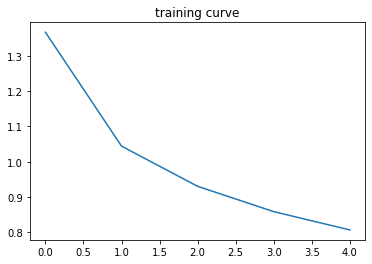

In [10]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(Loss))), Loss)
plt.title("training curve")

In [11]:
torch.save(model.state_dict(), 'cifar-10.ckpt')